In [8]:
import random
import nltk
import re
import pandas as pd 
import pickle
import spacy
import numpy as np
import multiprocessing
from copy import copy
import tensorflow as tf
from tqdm import tqdm
import json

from nltk.corpus import opinion_lexicon
import matplotlib.pyplot as plt
from copy import copy
import seaborn as sns   
import pandas as pd 
import string
from underthesea import word_tokenize
from underthesea import pos_tag

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download("opinion_lexicon")
nltk.download("vader_lexicon")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anhho\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anhho\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anhho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\anhho\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\anhho\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [9]:
df = pd.read_json("Dataset\data_posts.json")

In [10]:
df.head()

,attachments,user,likesCount,commentsCount,id,sharesCount,postId,hashtag,date,viewsCount,text,url,sharedPost,inputUrl
0,[{'thumbnail': 'https://scontent.fmem1-1.fna.f...,"{'id': '100064757463759', 'name': 'Pensilia', ...",17.0,0.0,UzpfSTEwMDA2NDc1NzQ2Mzc1OTo4MTk5NDEzNzY4NDExMD...,1.0,8.199414e+14,pensiliahcm,2024-03-19 05:00:40+00:00,182.0,Có phương nào phục hồi da nhiễm Corticoid khôn...,https://www.facebook.com/pensilia/posts/pfbid0...,NaN,NaN
1,[{'thumbnail': 'https://scontent.fmem1-2.fna.f...,"{'id': '100065319667574', 'name': 'Pensilia Sà...",2.0,0.0,UzpfSTEwMDA2NTMxOTY2NzU3NDo3NzQxNTY5NTE0MzgyOD...,0.0,7.741570e+14,pensiliahcm,2024-03-19 10:37:43+00:00,NaN,LÃO HÓA TRÊN GƯƠNG MẶT BẮT ĐẦU TỪ NHỮNG DẤU HI...,https://www.facebook.com/pensiliasaigon/posts/...,NaN,NaN
2,[{'thumbnail': 'https://scontent.fmem1-1.fna.f...,"{'id': '100064757463759', 'name': 'Pensilia', ...",16.0,0.0,UzpfSTEwMDA2NDc1NzQ2Mzc1OTo4MjEzMTg2NjY3MDMzNz...,1.0,8.213187e+14,pensiliahcm,2024-03-21 08:30:22+00:00,171.0,Cấy tinh chất tạo nét cân chỉnh toàn diện gươn...,https://www.facebook.com/pensilia/posts/pfbid0...,NaN,NaN
3,[{'thumbnail': 'https://scontent.fmem1-1.fna.f...,"{'id': '100063928750185', 'name': 'Pensilia Bi...",18.0,2.0,UzpfSTEwMDA2MzkyODc1MDE4NTo2ODY2MjE0MjY4MTIxND...,0.0,6.866214e+14,pensiliahcm,2023-07-19 03:12:39+00:00,107.0,Vài góc xinh đẹp tại Pensilia chi nhánh Đồng N...,https://www.facebook.com/PhongkhamPensiliaBien...,NaN,NaN
4,[{'thumbnail': 'https://scontent.fmem1-1.fna.f...,"{'id': '100064757463759', 'name': 'Pensilia', ...",9.0,0.0,UzpfSTEwMDA2NDc1NzQ2Mzc1OTo4MTc5Mjc3MTAzNzU4MD...,0.0,8.179277e+14,pensiliahcm,2024-03-16 01:00:35+00:00,221.0,Trán hõm má hóp có làm đầy bằng tinh chất được...,https://www.facebook.com/pensilia/posts/pfbid0...,NaN,NaN


In [11]:
# Function for loading stopwords from a file
def load_stopwords(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        stopwords = file.readlines()
    # Remove leading and trailing whitespaces, and newline characters
    stopwords = [word.strip() for word in stopwords]
    return stopwords

# Load Vietnamese stopwords from the file
stopwords_file = "Dataset/stopwords.txt"
vietnamese_stopwords = load_stopwords(stopwords_file)
fixed_words = ["Viện Nghiên Cứu", "học máy", "ko thoải mái", "k thoải mái", "vô trách nhiệm", "không hài lòng", "thất vọng", "không thấy đỡ", "khó mà tin tưởng",
               "khó tin tưởng", "phí thời gian", "nhăn cái mặt", "đầu đường só chợ", "vãi nồi", "không", "không trách nghiệm", "ko trách nghiệm", "không phản ánh đúng", "không giá trị"
               "khó tiếp cận", "không đảm bảo chất lượng", "ngu ngốc", 'lùa gà', 'mẹ thiên hạ', 'k hài lòng', "ko hiệu quả", "mất một đống tiền", "quá tệ",
               "vớ vẩn", "đem tiền quăng cửa sổ", "có như không", "không biết thật không nữa", "khổ_cả_đời", "mụn viêm", "không thân thiện", "không kiến thức",
               "không chuyên nghiệp", "Không giải quyết", "không đồng nhất", "chờ đợi lâu", "chờ lâu",
               "chả bao giờ", "k bao giờ", "tránh xa", "nhiều quá", "câu tương tác" , "không thấy cải thiện", "không thấy sự cải thiện",
               "gì cả", "không đáng tiền", "không đáng", "không như mong đợi", "đắt tiền", "không xứng đáng", 
               "không thấy sự thay đổi", "không cải thiện", "treo đầu dê bán thịt chó", "không tốt",
               "không đảm bảo", "không đúng", "không đáng tin cậy", "không đáng tin", "ko tư vấn", "không tư vấn", "không đáp ứng", "không trả lời", "không an toàn", "không đem lại hiệu quả", "không sự cải thiện",
               "không cải thiện", "không cải thiện", "không hết", "tốn tiền", "không hiệu quả", "không mang lại", "nói một đằng làm một nẻo",
               "không ai nghe", "không", "hên xui", "ko kết quả", "lúc nghe lúc không", "không tâm",
               "tránh xa", "kẻo lại", "k", "ko", "ko trách nghiệm", "không nhận được giá trị đáng đồng tiền", "mất lòng tin", "mất quá nhiều thời gian", "không thấy sự cải thiện",
               "không thấy hiệu quả", "quá lâu", "không thấy", "mất lịch sự", "vênh váo", "thiếu tôn trọng", "k lương tâm", "không thoải mái", "không tự tin", "giá cả", "tốn tiền", "chẳng_khác", "chả khác", "chả hiệu quả"
                "ko_thống_nhất", "ko", "mặt dày", "không trách nghiệm", "không chuyên nghiệp", "ko thân thiện", "không chất lượng", "không kiến thức", "không vệ sinh", "ko hiệu quả", "bắt máy", "không nói thẳng",
                "ko đáp ứng", "không cải thiện", "ko phản hồi", "ko uy tín", "liệu trình đắt tiền", "giá sinh viên", "trộm vía", "xinh gái"
]


import re
def preprocessing(text):
    global fixed_words
    text = str(text)
    # Lowercase
    text = text.lower()
    # Tokenization
    # Remove integers
    text = re.sub(r'\d+', '', text)
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)

    tokens = word_tokenize(text, format='text', fixed_words=fixed_words).split(' ')
    tokens = [token for token in tokens if token not in vietnamese_stopwords]
    return " ".join(tokens)


def remove_duplicates(my_list):
    return list(set(my_list))


In [12]:
df['text'] = df['text'].apply(preprocessing)

In [13]:
df['text']

0      phương phục_hồi da nhiễm corticoid không bác_s...
1      lão hóa gương_mặt dấu_hiệu không lão hóa cơ_ch...
2      cấy tinh_chất nét cân_chỉnh toàn_diện gương_mặ...
3      góc xinh_đẹp pensilia chi_nhánh đồng nai pensi...
4      trán hõm má hóp tinh_chất không bs cki_hoàng_t...
                             ...                        
382    bacsioi chanh_trị nám không mcv pensilia trina...
383    liên_hệ căng liên_hệ trảlời mcv pensilia bacsi...
384    haca radiesse kỹ_thuật tiêm cập_nhật bsnguyenp...
385    chiếu ánh_sáng nm nm phục_hồi da điều_trị tái_...
386                                                  nan
Name: text, Length: 387, dtype: object

In [14]:
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel
from nltk.corpus import stopwords
from pprint import pprint

In [15]:
data = []

for line in df['text']: 
    data.append(line.split(" "))

In [16]:
data

[['phương',
  'phục_hồi',
  'da',
  'nhiễm',
  'corticoid',
  'không',
  'bác_sĩ',
  'bác_sĩ',
  'cki_hoàng_thị',
  'hồng_trâm',
  'pensilia',
  'pensiliahcm',
  'phục_hồi_da'],
 ['lão',
  'hóa',
  'gương_mặt',
  'dấu_hiệu',
  'không',
  'lão',
  'hóa',
  'cơ_chế',
  'tự_nhiên',
  'cơ_thể',
  'con_người',
  'giai_đoạn',
  'trở',
  'đi',
  'làn',
  'da',
  'gương_mặt',
  'dễ_dàng',
  'dấu_hiệu',
  'lão',
  'hóa',
  'da',
  'sạm',
  'màu',
  'làn',
  'da',
  'sạm',
  'không',
  'màu',
  'sạm',
  'hai',
  'má',
  'trán',
  'da_mắt',
  'sắc_tố',
  'sậm',
  'màu',
  'đốm',
  'nâu',
  'gương_mặt',
  'đi_độ',
  'căng',
  'bóng',
  'khô',
  'sần',
  'rãnh',
  'cười',
  'sâu',
  'dấu_hiệu',
  'dễ_dàng',
  'báo_hiệu',
  'lão',
  'hóa',
  'nếp',
  'gấp',
  'cánh',
  'mũi',
  'sâu',
  'thông_thường',
  'da',
  'trẻ',
  'rãnh',
  'cười',
  'không',
  'hằn',
  'cười',
  'nếp',
  'gấp',
  'gương_mặt',
  'chảy',
  'xế',
  'lộ',
  'khuyết_điểm',
  'nếp',
  'nhăn',
  'đuôi',
  'mắt',
  'cau_mày',
  'bảo

In [17]:
dictionary = corpora.Dictionary(data)
corpus = [dictionary.doc2bow(text) for text in data]

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=15)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [21]:
start, limit, step = 2, 21, 1
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=data, start=start, limit=limit, step=step)

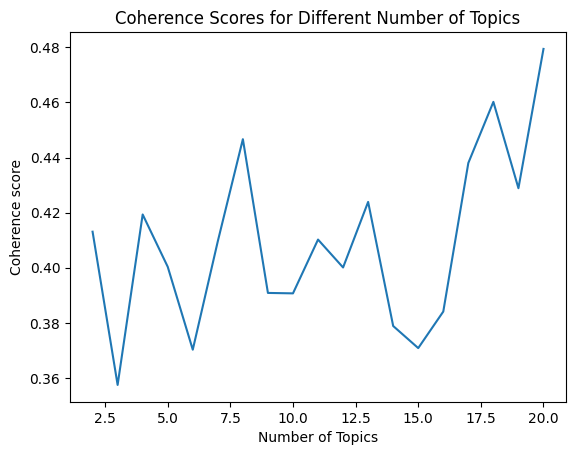

In [22]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.title("Coherence Scores for Different Number of Topics")
plt.show()

In [39]:
best_model = model_list[2]

In [40]:
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis  # Depending on the version, gensim_models might be required

pyLDAvis.enable_notebook()

# Prepare the visualization for the best model
vis = gensimvis.prepare(best_model, corpus, dictionary)
pyLDAvis.display(vis)


In [25]:
best_model_index = coherence_values.index(max(coherence_values))
best_model = model_list[best_model_index]

# Visualize the best LDA model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
pyLDAvis.display(vis)

AttributeError: module 'pyLDAvis' has no attribute 'gensim_models'